*   Title: Linear Regression on california housing prices
*   Author: Rupesh Biradar
*   Date: 'June 21 2021'

In [ ]:
# gather all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# load the dataset and display the summary of the dataset
housing_dataset = pd.read_csv("https://raw.githubusercontent.com/rupeshbiradar40/California-housing-prices-regression-analysis/main/housing.csv")
housing_dataset.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# know dataset and features
print('Number of rows in Dataset : ', len(housing_dataset.index))
print('Number of colums in Dataset : ', len(housing_dataset.columns))
print('Diamention of the dataset : ', housing_dataset.shape)
print('size of the dataset :', housing_dataset.size)
print('Feature attributes:', housing_dataset.columns)

Number of rows in Dataset :  20640
Number of colums in Dataset :  10
Diamention of the dataset :  (20640, 10)
size of the dataset : 206400
Feature attributes: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


In [ ]:
# know stats of dataset
housing_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing_dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
# we have one categorial feature, so let's get cound of datapoints in each category of ocean_proximity feature
housing_dataset['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

By observing the dataset we found out that there are two problems in the dataset.
1. ocean proximity is a categorial data feature which needs to be converted into numerical values by using one of the encoding techniques
2. there are missing values present for total_bedrooms data feature which needs to be addressed.

In [ ]:
# prepare the dataset with data cleaning and preprocessing

# convert ocean-proximity categorial feature into one hot encoded set of vector
from sklearn.preprocessing import OneHotEncoder
categorial_data, categories = housing_dataset['ocean_proximity'].factorize()
categorial_data_array = OneHotEncoder().fit_transform(categorial_data.reshape(-1,1)).toarray()
encoded_dataset = housing_dataset.iloc[:,0:9].copy()
for i in range(0,len(categories)):
  encoded_dataset[categories[i]] = categorial_data_array[:,i]

encoded_dataset.head(5)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,1.0,0.0,0.0,0.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1.0,0.0,0.0,0.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,1.0,0.0,0.0,0.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,1.0,0.0,0.0,0.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# use imputer class from sklearn library to fint out null values for total_bedrooms features and replace with the median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(encoded_dataset)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
X = imputer.transform(encoded_dataset)
transformed_housing_dataset = pd.DataFrame(X,columns=encoded_dataset.columns)
transformed_housing_dataset.isnull().values.any()


False

Output of above line of code is "False" it means all the data is cleaned now where we replaced null values from total_bedrooms with their medain values feature and also encoded the categorial data into one hot encoded vectors.

We can use this dataset to further divide it in train and test set for linear regression model.

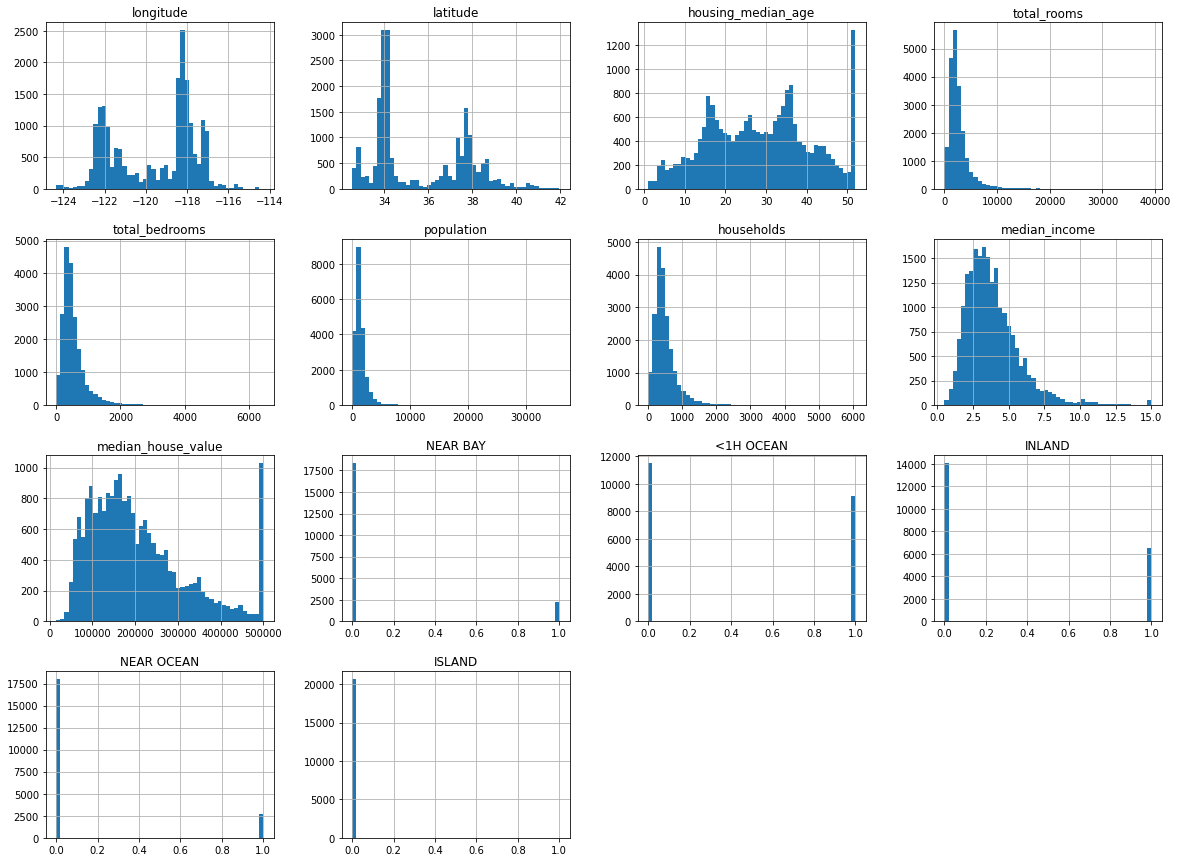

In [ ]:
transformed_housing_dataset.hist(bins=50, figsize=(20,15))

# as the other data features don't seem normalized, we will perform stratified sampling for creating robust train and test sets
transformed_housing_dataset['median_income'].hist()

#divide median income to limit the numer of median income categorties
transformed_housing_dataset['median_income_category'] = np.ceil(transformed_housing_dataset['median_income'] / 1.5)

# merging everything after last category into last category
transformed_housing_dataset['median_income_category'].where(transformed_housing_dataset['median_income_category'] < 5, other=5.0, inplace=True)

In [ ]:
#perform stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.2, random_state=29)

for train_index, test_index in split.split(transformed_housing_dataset, transformed_housing_dataset['median_income_category']):
  stratefied_train_set = transformed_housing_dataset.loc[train_index]
  stratefied_test_set = transformed_housing_dataset.loc[test_index]

In [ ]:
# verify the percentage of value counts for each category to confirm stratified sampling is done properly
transformed_housing_dataset['median_income_category'].value_counts() / len(housing_dataset)
stratefied_train_set['median_income_category'].value_counts() / len(stratefied_train_set)
stratefied_test_set['median_income_category'].value_counts() / len(stratefied_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: median_income_category, dtype: float64

with above results we can conclude that the proportions of each income categorty is maintained in both train and test set identical to original data using stratified sampling. This helps to not to missout any class of any class of data for such dataset which has less feature-space

In [ ]:
for indexes in (stratefied_train_set, stratefied_test_set):
  indexes.drop('median_income_category', axis=1,)

In [ ]:
# apply regression model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
linear_regression.fit(stratefied_train_set.iloc[:,[idx for idx in range(len(stratefied_train_set.columns)) if idx != 8]], stratefied_train_set['median_house_value'])
predictions = linear_regression.predict(stratefied_test_set.iloc[:,[idx for idx in range(len(stratefied_test_set.columns)) if idx != 8]])


In [ ]:
# calculate root mean square error
RMSE = np.sqrt(mean_squared_error(stratefied_test_set['median_house_value'], predictions))
print(RMSE)

68172.00956359101


We trained a linear regression model based on our training set. Then, we used it to predict the house price on our test set, and we have computed the RMSE to quantify model accuracy. But RMSE we have received is very high. It means our regression model is not performing well.

We will visualize data and find correlation between the features and try adding custom features in the dataset to see if increases the accuracy.

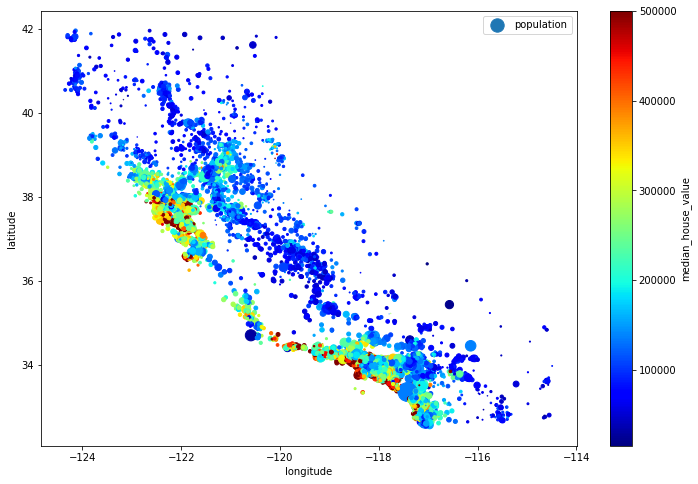

In [ ]:
# visualize the data instances across locational attributes like latitude, longitude etc.
stratefied_train_set_copy = stratefied_train_set.copy()
stratefied_train_set_copy.plot(kind='scatter', x='longitude', y='latitude', s=housing_dataset_copy['population']/100, label="population", figsize=(12,8),
                     c='median_house_value',cmap=plt.get_cmap("jet"), sharex=False)

In [ ]:
correlation_matrix = stratefied_train_set_copy.corr()
correlation_matrix['median_house_value']

longitude                -0.046734
latitude                 -0.142906
housing_median_age        0.100233
total_rooms               0.136959
total_bedrooms            0.052042
population               -0.022075
households                0.067895
median_income             0.689990
median_house_value        1.000000
NEAR BAY                  0.163808
<1H OCEAN                 0.255474
INLAND                   -0.482224
NEAR OCEAN                0.135816
ISLAND                    0.026095
median_income_category    0.645704
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd87e3e82d0>,
      dtype=object)

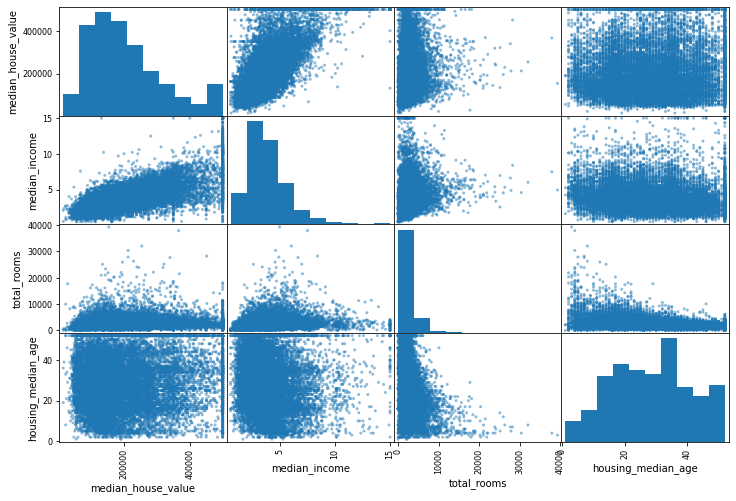

In [ ]:
# looking at the correlation matrix median_income, median_house_value, total_rooms, housing_median_age are important features
# plot these features to visualize feature correlation in detail
important_features = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
from pandas.plotting import scatter_matrix
scatter_matrix(stratefied_train_set_copy[important_features], figsize=(12,8))

#observations: 
1. median_income is most important feature for median_house_value 
2. regions with highest population has higher median_house_value
3. houses near ocean or near bay has higher median_house_value


In [ ]:
# now we have found out the correlation, we will create our own custom features to build strong model as we have very few features with us right now
# we can create features like population per household, total bedrooms per house, total_household, total_rooms, total_bedrooms etc
# new train and test set with custom features
stratefied_train_set_copy['rooms_per_household']=stratefied_train_set_copy['total_rooms']/stratefied_train_set_copy['households']
stratefied_train_set_copy['bedrooms_per_house']=stratefied_train_set_copy['total_bedrooms']/stratefied_train_set_copy['total_rooms']
stratefied_train_set_copy['population_per_household']=stratefied_train_set_copy['population']/stratefied_train_set_copy['households']


In [ ]:
stratefied_test_set_copy = stratefied_test_set.copy()

stratefied_test_set_copy['rooms_per_household']=stratefied_test_set_copy['total_rooms']/stratefied_test_set_copy['households']
stratefied_test_set_copy['bedrooms_per_house']=stratefied_test_set_copy['total_bedrooms']/stratefied_test_set_copy['total_rooms']
stratefied_test_set_copy['population_per_household']=stratefied_test_set_copy['population']/stratefied_test_set_copy['households']


In [ ]:
# apply regression model agian

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
linear_regression.fit(stratefied_train_set_copy.iloc[:,[idx for idx in range(len(stratefied_train_set_copy.columns)) if idx != 8]], stratefied_train_set_copy['median_house_value'])
prediction = linear_regression.predict(stratefied_test_set_copy.iloc[:,[idx for idx in range(len(stratefied_test_set_copy.columns)) if idx != 8]])

In [ ]:
# calculate root mean square error
RMSE = np.sqrt(mean_squared_error(stratefied_test_set_copy['median_house_value'], prediction))
print(RMSE)

67734.27106587362


# Conclusion
Comparing the RMSE for both the models we can conclude that, the model with custom added fatures works well than the raw dataset feature.

But, Linear regression is clearly not the best machine learning model for predicting the house prices for this specific dataset. 